In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.autograd import Variable
import sys, inspect
sys.path.insert(0, '..')

%matplotlib inline
import pymc
import matplotlib.pyplot as plt

from learn_smc_proposals import cde
from learn_smc_proposals.utils import systematic_resample

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

import itertools

Define 3 binary variables joint distribution

In [2]:
a = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
a = a/np.sum(a)
a.shape

(2, 2, 2)

In [3]:
a

array([[[ 0.02777778,  0.05555556],
        [ 0.08333333,  0.11111111]],

       [[ 0.13888889,  0.16666667],
        [ 0.19444444,  0.22222222]]])

Check if not independent

In [4]:
marginal = lambda i: a.sum(axis=tuple({0,1,2}.difference({i})))

In [5]:
for i in itertools.product([0, 1], repeat=3):
    assert(not np.isclose(marginal(0)[i[0]]*marginal(1)[i[1]]*marginal(2)[i[2]], a[i[0],i[1],i[2]]))

Sample values

In [6]:
def generate_synthetic(size=100):
    size = int(size)
    c = np.digitize(np.random.uniform(size=(size,1)), np.cumsum(a))
    d = np.unravel_index(c, a.shape)
    e = np.squeeze(np.dstack(d))
    latent = np.atleast_2d(e)
    return latent

gen_data = lambda num_samples: generate_synthetic(num_samples)
example_minibatch = gen_data(100)

In [7]:
n = 1000000
aa = np.unique(gen_data(n), axis=0,return_counts=True)[1]
aa/aa[0]

array([ 1.        ,  1.98240764,  3.00244139,  3.98782896,  4.98825979,
        5.97558611,  6.9895882 ,  7.9766632 ])

In [8]:
observed_dim = 0

latent_dim = 3
hidden_units = 1
hidden_layers = 1

dist_est = cde.ConditionalBinaryMADE(observed_dim, latent_dim, hidden_units, hidden_layers)
if torch.cuda.is_available():
    dist_est.cuda()

dist_est

ConditionalBinaryMADE(
  (relu): ReLU()
  (layers): ModuleList(
    (0): MaskedLinear(in_features=3, out_features=1)
  )
  (skip_p): MaskedLinear(in_features=3, out_features=3)
  (skip_q): MaskedLinear(in_features=3, out_features=3)
  (p): MaskedLinear(in_features=1, out_features=3)
  (q): MaskedLinear(in_features=1, out_features=3)
  (loss): BCELoss(
  )
)

In [9]:
example_latents = Variable(torch.FloatTensor(example_minibatch[0:5]))
if torch.cuda.is_available():
    example_latents = example_latents.cuda()

print("Sampled from p(latent|parents):\n\n", dist_est.sample(cuda=True))
print("Evaluate log p(latent|parents):\n\n", dist_est.logpdf(example_latents))

Sampled from p(latent|parents):

 Variable containing:
 0  1  1
[torch.cuda.FloatTensor of size 1x3 (GPU 0)]

Evaluate log p(latent|parents):

 Variable containing:
-2.0784
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [10]:
temp = [list(i) for i in itertools.product([0, 1], repeat=3)]
probs = []
for i in temp:
    example_latents = Variable(torch.FloatTensor([i]))
    if torch.cuda.is_available():
        example_latents = example_latents.cuda()
    temp_prob = np.exp(dist_est.logpdf(example_latents).data.cpu().numpy())
    probs.append(temp_prob)
probs = np.array(probs)
probs/probs[0]

array([[ 1.        ],
       [ 1.00251591],
       [ 0.99922496],
       [ 0.9903124 ],
       [ 1.00439131],
       [ 1.00264347],
       [ 1.01332104],
       [ 1.00001931]], dtype=float32)

## Optimize network parameters

The `training_epoch` code samples a synthetic dataset, and performs minibatch updates on it for a while. Optionally, it can decide when to stop by examining synthetic validation data.

In [11]:
def _iterate_minibatches(outputs, batchsize):
    for start_idx in range(0, len(outputs) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield Variable(torch.FloatTensor(outputs[excerpt]))

def training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, max_local_iters=10, misstep_tolerance=0, verbose=False):
    """ Training function for fitting density estimator to simulator output """
    # Train
    synthetic_outs = gen_data(dataset_size)
    validation_size = dataset_size/10
    validation_outs = Variable(torch.FloatTensor(gen_data(validation_size)))
    missteps = 0
    num_batches = float(dataset_size)/batch_size
    
    USE_GPU = dist_est.parameters().__next__().is_cuda
    if USE_GPU:
        validation_outs = validation_outs.cuda()
    
    validation_err = -torch.mean(dist_est.logpdf(validation_outs)).data[0]
    for local_iter in range(max_local_iters):
        train_err = 0
        for outputs in _iterate_minibatches(synthetic_outs, batch_size):
            optimizer.zero_grad()
            if USE_GPU:
                loss = -torch.mean(dist_est.logpdf(outputs.cuda()))
            else:
                loss = -torch.mean(dist_est.logpdf(outputs))
            loss.backward()
            optimizer.step()
            train_err += loss.data[0]/num_batches
            
        next_validation_err = -torch.mean(dist_est.logpdf(validation_outs)).data[0]
        if next_validation_err > validation_err:
            missteps += 1
        validation_err = next_validation_err
        if missteps > misstep_tolerance:
            break
    
    if verbose:
        print(train_err, validation_err, "(", local_iter+1, ")")
#         print(list(dist_est.parameters()))
        
    return train_err, validation_err, local_iter+1

In [12]:
optimizer = torch.optim.Adam(dist_est.parameters())
trace_train = []
trace_validation = []
trace_local_iters = []

In [13]:
num_iterations = 100
dataset_size = 100000
batch_size = 5000

for i in range(num_iterations):
    verbose = (i+1) % 100 == 0
    if verbose:
        print("["+str(1+len(trace_train))+"]")
    t,v,l = training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, verbose=verbose, max_local_iters=1)
    trace_train.append(t)
    trace_validation.append(v)
    trace_local_iters.append(l)

[100]
1.9393263936042788 1.933097004890442 ( 1 )


In [14]:
temp = [list(i) for i in itertools.product([0, 1], repeat=3)]
probs = []
for i in temp:
    example_latents = Variable(torch.FloatTensor([i]))
    if torch.cuda.is_available():
        example_latents = example_latents.cuda()
    temp_prob = np.exp(dist_est.logpdf(example_latents).data.cpu().numpy())
    probs.append(temp_prob)
probs = np.array(probs)

<Container object of 8 artists>

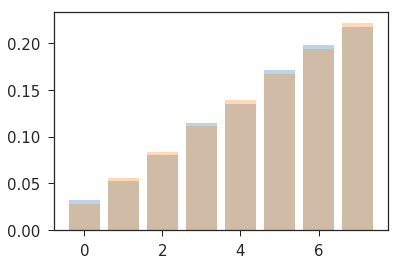

In [15]:
alpha = .3
plt.bar(np.arange(8), probs.flatten().T, alpha=alpha)
plt.bar(np.arange(8), a.flatten().T, alpha=alpha)

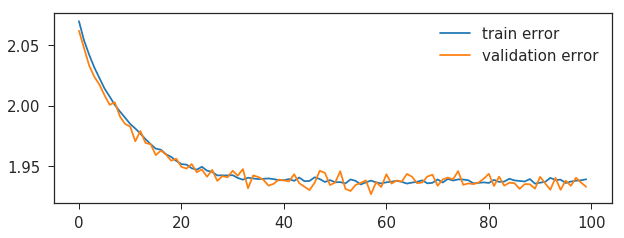

In [16]:
plt.figure(figsize=(10,3.5))
plt.plot(np.array(trace_train))
plt.plot(np.array(trace_validation))
plt.legend(['train error', 'validation error']);